In [23]:
import sys
sys.path.append("subspaces")

import torch
import torchvision
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm

%matplotlib inline

# Download MNIST dataset
emnist_train = torchvision.datasets.EMNIST('./emnist', download=True,train=True,split='digits')
emnist_eval = torchvision.datasets.EMNIST('./emnist', download=True,train=False,split='digits')

In [24]:
# Transform data in a tensor of form [batch, image_data]
# Create list of correct_labels for train and eval sets

vector_size = 28*28

train_data = torch.empty(len(emnist_train), vector_size)
train_correct_labels = []

eval_data = torch.empty(len(emnist_eval), vector_size)
eval_correct_labels = []

for i in range(len(emnist_train)):
    train_data[i] = torch.squeeze(torchvision.transforms.functional.to_tensor(emnist_train[i][0])).flatten()
    train_correct_labels.append(emnist_train[i][1])

for i in range(len(emnist_eval)):
    eval_data[i] = torch.squeeze(torchvision.transforms.functional.to_tensor(emnist_eval[i][0])).flatten()
    eval_correct_labels.append(emnist_eval[i][1])

In [25]:
from subspaces.vector_set import VectorSet
from subspaces.vector_space import VectorSpace

tmp_set = VectorSet([i for i in range(10)], vector_size=vector_size)
tmp_set.populate(eval_data, eval_correct_labels)

eval_subspaces = []
eval_correct_labels = []

for subspace in tmp_set:
    for i in range(0, 3999-10, 10):
        tmp_subspace = VectorSpace(vector_size=vector_size, label=subspace.label)
        tmp_subspace.append(subspace.A[i:i+10])
        eval_subspaces.append(tmp_subspace)
        eval_correct_labels.append(subspace.label)

In [26]:
from subspaces.vector_msm import VectorMSM

min_energy_list = torch.linspace(0.05, 0.95, 19)
ratio = []
for min_energy in tqdm(min_energy_list):
    # Train with min_energy
    model = VectorMSM(vector_size=vector_size)
    model.train(train_data, train_correct_labels, min_energy=min_energy)

    # Predict
    predition_list, prediction_ratio = model.eval(eval_subspaces, eval_correct_labels)
    print(min_energy, prediction_ratio)
    ratio.append(prediction_ratio)

  0%|          | 0/19 [00:00<?, ?it/s]

tensor(0.0500) 0.9518796992481203
tensor(0.1000) 0.4942355889724311
tensor(0.1500) 0.5802005012531328
tensor(0.2000) 0.4573934837092732
tensor(0.2500) 0.46766917293233085
tensor(0.3000) 0.38822055137844613
tensor(0.3500) 0.3581453634085213
tensor(0.4000) 0.30952380952380953
tensor(0.4500) 0.2571428571428571
tensor(0.5000) 0.23759398496240602
tensor(0.5500) 0.20451127819548873
tensor(0.6000) 0.17067669172932332
tensor(0.6500) 0.1393483709273183
tensor(0.7000) 0.12431077694235589
tensor(0.7500) 0.11378446115288221
tensor(0.8000) 0.10401002506265664
tensor(0.8500) 0.10150375939849623
tensor(0.9000) 0.10050125313283208
tensor(0.9500) 0.1


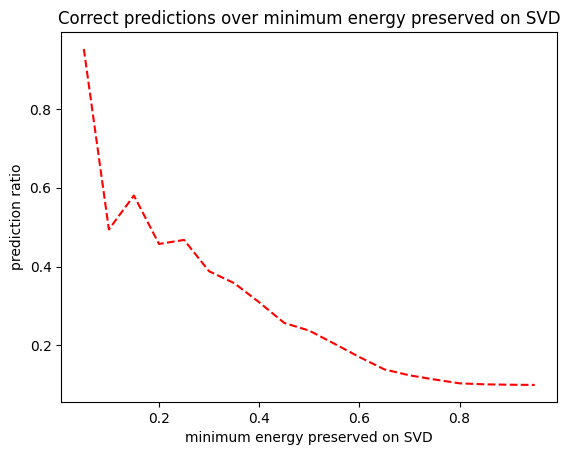

In [27]:
import matplotlib.pyplot as plt

plt.plot(min_energy_list.numpy(), ratio, 'r--')
plt.title("Correct predictions over minimum energy preserved on SVD")
plt.xlabel("minimum energy preserved on SVD")
plt.ylabel("prediction ratio")
plt.show()

In [28]:
# Nice.
# The more energy is used to form the basis of the signal, the worse is the performance, as
# more noise is added it the subspace bases.

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.0100) 0.9518796992481203
tensor(0.0200) 0.9518796992481203
tensor(0.0300) 0.9518796992481203
tensor(0.0400) 0.9518796992481203
tensor(0.0500) 0.9518796992481203
tensor(0.0600) 0.9518796992481203
tensor(0.0700) 0.9518796992481203
tensor(0.0800) 0.9518796992481203
tensor(0.0900) 0.6724310776942356
tensor(0.1000) 0.4942355889724311


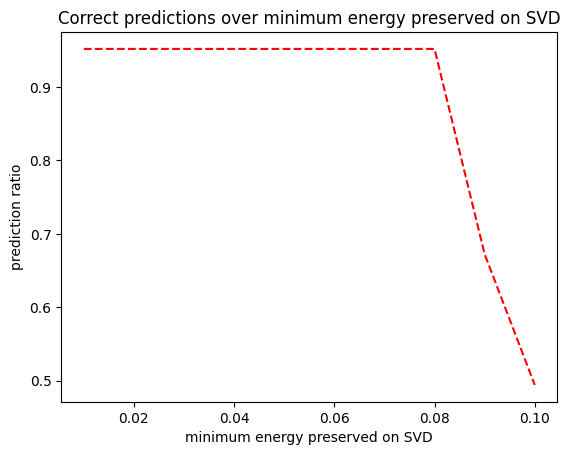

In [29]:
# Repeating above experiment focusing on the 0.01 ~ 0.1 energy range

min_energy_list = torch.linspace(0.01, 0.1, 10)
ratio = []
for min_energy in tqdm(min_energy_list):
    # Train with min_energy
    model = VectorMSM(vector_size=vector_size)
    model.train(train_data, train_correct_labels, min_energy=min_energy)

    # Predict
    predition_list, prediction_ratio = model.eval(eval_subspaces, eval_correct_labels)
    print(min_energy, prediction_ratio)
    ratio.append(prediction_ratio)

import matplotlib.pyplot as plt

plt.plot(min_energy_list.numpy(), ratio, 'r--')
plt.title("Correct predictions over minimum energy preserved on SVD")
plt.xlabel("minimum energy preserved on SVD")
plt.ylabel("prediction ratio")
plt.show()

In [30]:
# There is an abrupt degrade on performance as the number of bases grow. Let's plot some cossine similarities of a full signal

model = VectorMSM(vector_size=vector_size)
model.train(train_data, train_correct_labels, min_energy=1)

VectorSpace:10x784 VectorSpace:758x784


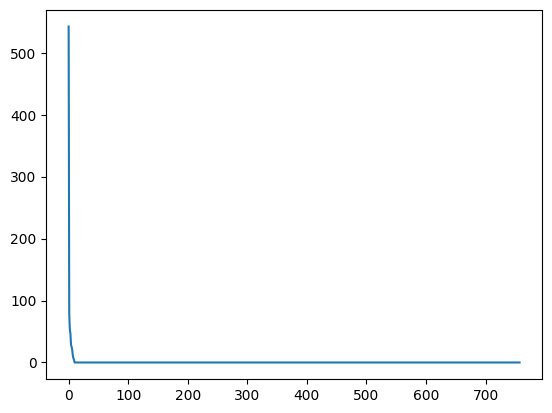

In [59]:
print(eval_subspaces[0], model.subset[0])
cossine_similarities = model.cossine_similarity([eval_subspaces[0]], model.subset[0])
plt.plot(cossine_similarities.squeeze())